# Loan predictions

## Problem Statement

We want to automate the loan eligibility process based on customer details that are provided as online application forms are being filled. You can find the dataset [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing). These details concern the customer's Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and other things as well. 

|Variable| Description|
| ------------- |-------------|
|Loan_ID| Unique Loan ID|
|Gender| Male/ Female|
|Married| Applicant married (Y/N)|
|Dependents| Number of dependents|
|Education| Applicant Education (Graduate/ Under Graduate)|
|Self_Employed| Self employed (Y/N)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands|
|Loan_Amount_Term| Term of loan in months|
|Credit_History| credit history meets guidelines|
|Property_Area| Urban/ Semi Urban/ Rural|
|Loan_Status| Loan approved (Y/N)



### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

## 1. Hypothesis Generation

Generating a hypothesis is a major step in the process of analyzing data. This involves understanding the problem and formulating a meaningful hypothesis about what could potentially have a good impact on the outcome. This is done BEFORE looking at the data, and we end up creating a laundry list of the different analyses which we can potentially perform if data is available.

#### Possible hypotheses
Which applicants are more likely to get a loan

1. Applicants having a credit history 
2. Applicants with higher applicant and co-applicant incomes
3. Applicants with higher education level
4. Properties in urban areas with high growth perspectives

Do more brainstorming and create some hypotheses of your own. Remember that the data might not be sufficient to test all of these, but forming these enables a better understanding of the problem.

## 2. Data Exploration
Let's do some basic data exploration here and come up with some inferences about the data. Go ahead and try to figure out some irregularities and address them in the next section. 

### Import Packages

In [98]:
# common packages
import pandas as pd
import numpy as np

# setup specific packages
from pathlib import Path

# exploratory packages
from matplotlib import pyplot as plt
from scipy.stats import shapiro

In [99]:
data_path = Path('./res')
df = pd.read_csv(data_path / 'loan_data.csv') 

### Isolate Target Variable and Prune Features

One of the key challenges in any data set are missing values. Lets start by checking which columns contain missing values.

In [100]:
# proportion of data that is null or missing
print(df.isnull().sum()[df.isnull().sum() / df.shape[0] !=0 ])
print(df.shape)

Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64
(614, 13)


In [101]:
# drop rows where there are missing values for categorical
df.dropna(
    subset=[
        'Gender', 
        'Married', 
        'Dependents', 
        'Self_Employed', 
        'Credit_History'],
    axis=0,
    inplace=True)

df.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           19
Loan_Amount_Term     12
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [102]:
df = df.assign(Loan_Status=[1 if item == 'Y' else 0 for item in df.Loan_Status])

In [103]:
# drop target and loan_id features
x = df.drop(columns=['Loan_Status', 'Loan_ID'])
y = df['Loan_Status']

### `Function`: Separate Numerical and Categorical

In [104]:
x[['Loan_Amount_Term', 'Credit_History']] = x[['Loan_Amount_Term', 'Credit_History']].astype('object')

In [105]:
def num_select(data):
    data = data[data.columns[data.dtypes != object]]
    return data

def cat_select(data):
    data = data[data.columns[data.dtypes == object]]
    return data

In [106]:
xnums = num_select(x)
xcats = cat_select(x)

### Numerical: Statistics

1. How many applicants have a `Credit_History`? (`Credit_History` has value 1 for those who have a credit history and 0 otherwise)

In [107]:
print('Applicants whose credit history does not meet guidelines:',(xcats['Credit_History'] == 0).sum())

Applicants whose credit history does not meet guidelines: 80


2. Is the `ApplicantIncome` distribution in line with your expectation? Similarly, what about `CoapplicantIncome`?

In [108]:
# grab the shapiro stats for normal distributions
tstat = {}
pval = {}

for i,col in enumerate(xnums.columns):
    t,p = shapiro(xnums[col])
    
    tstat[col] = t
    pval[col] = p
    
print(tstat)
print(pval)

{'ApplicantIncome': 0.4949631690979004, 'CoapplicantIncome': 0.5591318607330322, 'LoanAmount': nan}
{'ApplicantIncome': 1.252874939885011e-35, 'CoapplicantIncome': 7.037506517510489e-34, 'LoanAmount': 1.0}


> According to pval, `LoanAmount` follows a normal distribution, while the others do not.

3. Tip: Can you see a possible skewness in the data by comparing the mean to the median, i.e. the 50% figure of a feature.

In [109]:
print(xnums['LoanAmount'].skew())
print(xnums['ApplicantIncome'].skew())
print(xnums['CoapplicantIncome'].skew())

2.387942560875531
6.944482761188726
5.93008656626681


### Categorical: Statistics

In [110]:
for col in xcats.columns:
    print(col, xcats[col].unique())

Gender ['Male' 'Female']
Married ['No' 'Yes']
Dependents ['0' '1' '2' '3+']
Education ['Graduate' 'Not Graduate']
Self_Employed ['No' 'Yes']
Loan_Amount_Term [360.0 120.0 nan 180.0 60.0 300.0 480.0 240.0 36.0 84.0]
Credit_History [1.0 0.0]
Property_Area ['Urban' 'Rural' 'Semiurban']


Explore further using the frequency of different categories in each nominal variable. Exclude the ID obvious reasons.

In [111]:
for col in xcats.columns:
    print(col, xcats[col].value_counts().to_list())

Gender [420, 91]
Married [331, 180]
Dependents [294, 88, 85, 44]
Education [401, 110]
Self_Employed [441, 70]
Loan_Amount_Term [428, 38, 12, 9, 3, 3, 2, 2, 2]
Credit_History [431, 80]
Property_Area [197, 165, 149]


### Numerical: Distribution Analysis


Study distribution of various variables. Plot the histogram of ApplicantIncome, try different number of bins.



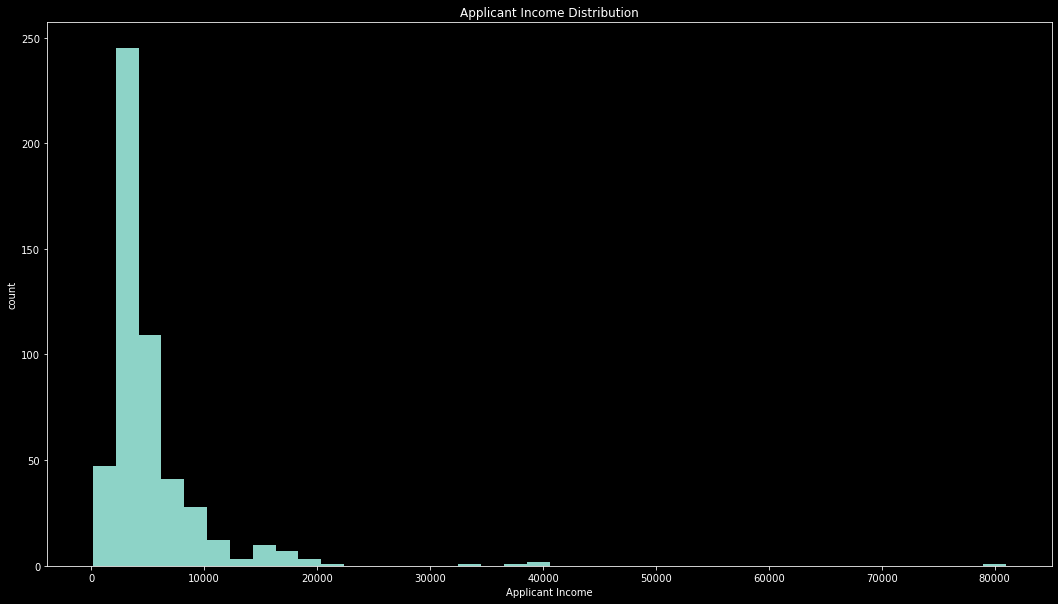

In [112]:
plt.figure(figsize=(18,10))
plt.title('Applicant Income Distribution')
plt.xlabel('Applicant Income')
plt.ylabel('count')
plt.hist(xnums['ApplicantIncome'], bins=40)

plt.show()

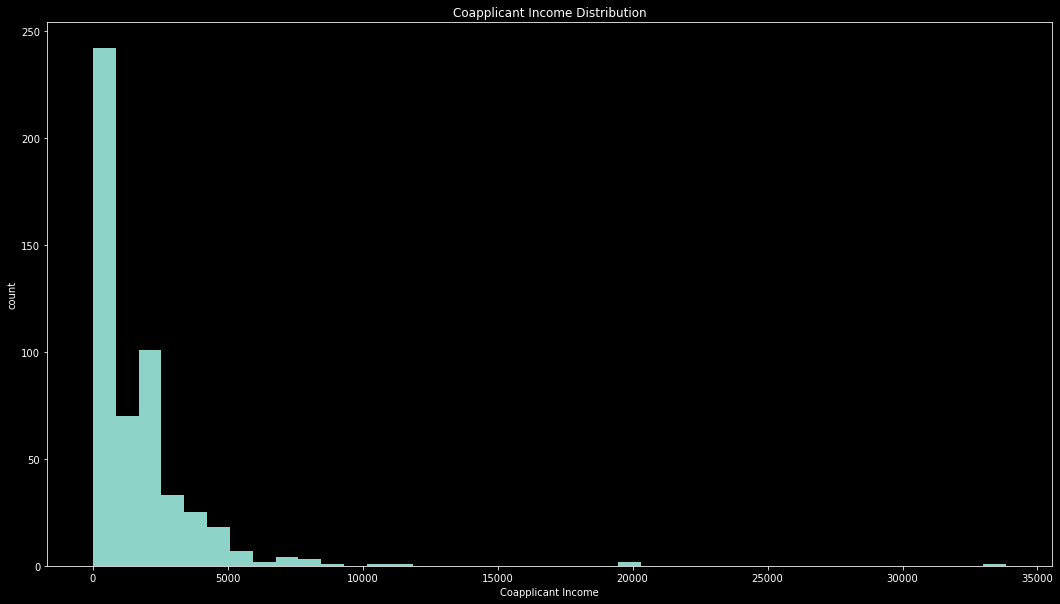

In [113]:
plt.figure(figsize=(18,10))
plt.title('Coapplicant Income Distribution')
plt.xlabel('Coapplicant Income')
plt.ylabel('count')
plt.hist(xnums['CoapplicantIncome'], bins=40)

plt.show()


Look at box plots to understand the distributions. 

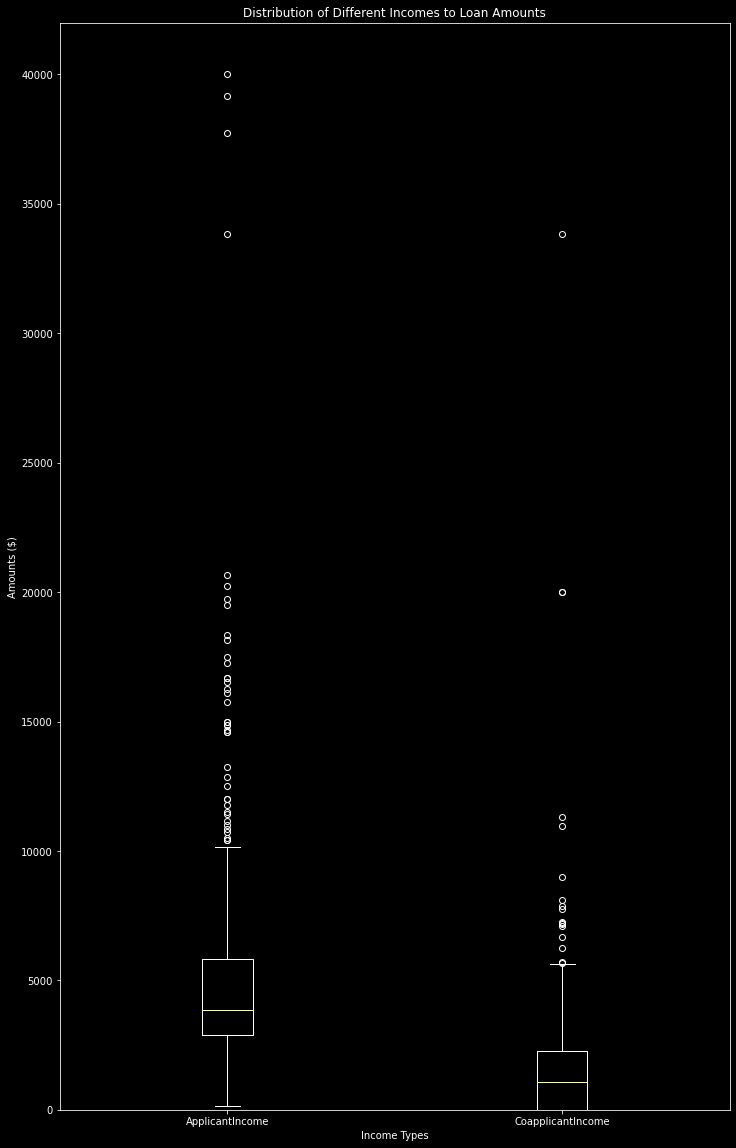

In [114]:
fig, ax = plt.subplots(figsize=(12,20))
ax.set_title('Distribution of Different Incomes to Loan Amounts')
ax.set_ylabel('Amounts ($)')
ax.set_xlabel('Income Types')
ax.set_ylim(0, 42000)
ax.boxplot(xnums[['ApplicantIncome', 'CoapplicantIncome']], labels=xnums.columns[:2])

plt.show()

Look at the distribution of income segregated  by `Education`

In [115]:
graduates = x[x['Education'] == 'Graduate']
notGraduates = x[x['Education'] == 'Not Graduate']

In [116]:
graduates['ApplicantIncome'].describe()

count      401.000000
mean      5723.516209
std       6092.577861
min        150.000000
25%       3029.000000
50%       4009.000000
75%       6250.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

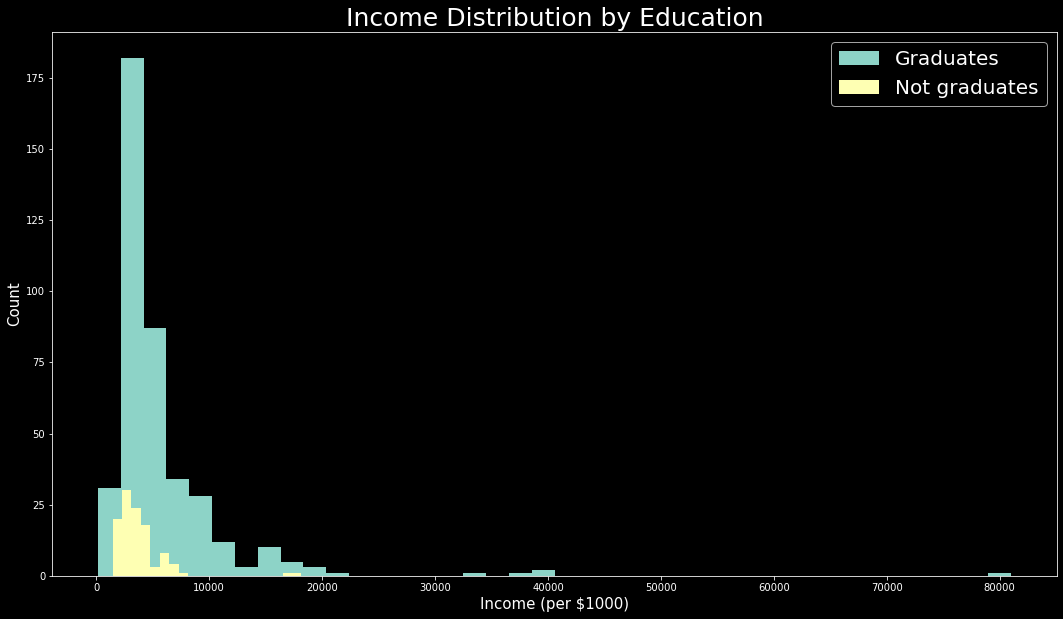

In [117]:
fig,ax = plt.subplots(figsize=(18,10))
ax.set_title('Income Distribution by Education', fontsize=25)
ax.set_xlabel('Income (per $1000)', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.hist(graduates['ApplicantIncome'], bins=40, label='Graduates')
ax.hist(notGraduates['ApplicantIncome'], bins=20, label='Not graduates')
ax.legend(fontsize=20)
plt.show()


Look at the histogram and boxplot of LoanAmount

(array([  9.,  33.,  67., 136.,  98.,  58.,  35.,  14.,  12.,  10.,   6.,
          2.,   2.,   1.,   1.,   2.,   3.,   0.,   1.,   2.]),
 array([  9.  ,  38.55,  68.1 ,  97.65, 127.2 , 156.75, 186.3 , 215.85,
        245.4 , 274.95, 304.5 , 334.05, 363.6 , 393.15, 422.7 , 452.25,
        481.8 , 511.35, 540.9 , 570.45, 600.  ]),
 <BarContainer object of 20 artists>)

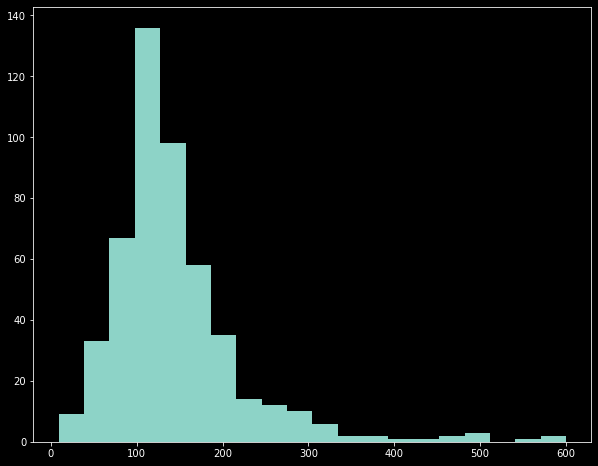

In [118]:
plt.figure(figsize=(10,8))
plt.hist(xnums['LoanAmount'], bins=20)

There might be some extreme values. Both `ApplicantIncome` and `LoanAmount` require some amount of data munging. `LoanAmount` has missing and well as extreme values values, while `ApplicantIncome` has a few extreme values, which demand deeper understanding. 

### Categorical: Variable Analysis

Try to understand categorical variables in more details using `pandas.DataFrame.pivot_table` and some visualizations.

In [119]:
pd.pivot_table(x, values=['ApplicantIncome', 'CoapplicantIncome'], index=['Married', 'Education'])

ApplicantIncome  CoapplicantIncome
Married Education                                       
No      Graduate          5217.546099        1322.432624
        Not Graduate      4236.974359         710.589744
Yes     Graduate          5997.907692        1830.472769
        Not Graduate      3550.577465        1522.281690

## 3. Data Cleaning

This step typically involves imputing missing values and treating outliers. 

### Imputing Missing Values

Missing values may not always be NaNs. For instance, the `Loan_Amount_Term` might be 0, which does not make sense.

Impute missing values for all columns. Use the values which you find most meaningful (mean, mode, median, zero.... maybe different mean values for different groups)

In [120]:
from sklearn.impute import SimpleImputer

In [121]:
# find 0-values in categorical features
print(xcats.isnull().sum(),'\n')
print('0-term Loans:')
for col in xcats.columns:
      print(col, (xcats[col] == 0).sum()),

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
Loan_Amount_Term    12
Credit_History       0
Property_Area        0
dtype: int64 

0-term Loans:
Gender 0
Married 0
Dependents 0
Education 0
Self_Employed 0
Loan_Amount_Term 0
Credit_History 80
Property_Area 0


In [122]:
# find 0-values in numerical features
print(xnums.isnull().sum(),'\n')
for col in xnums.columns:
      print(col, (xnums[col] == 0).sum()),

ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           19
dtype: int64 

ApplicantIncome 0
CoapplicantIncome 230
LoanAmount 0


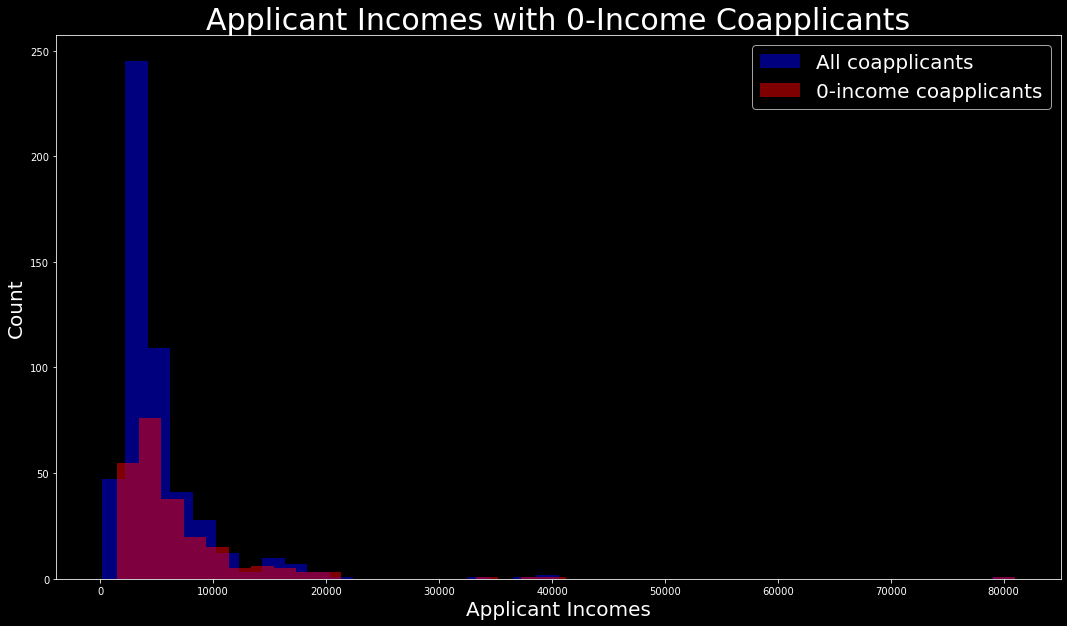

In [123]:
# isolate the 0-values and plot
zero_incomes = x[x['CoapplicantIncome'] == 0]

plt.subplots(figsize=(18,10))
plt.title('Applicant Incomes with 0-Income Coapplicants', fontsize=30)
plt.xlabel('Applicant Incomes', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.hist(xnums['ApplicantIncome'], bins=40, alpha=0.5, color='blue', label='All coapplicants')
plt.hist(zero_incomes['ApplicantIncome'], bins=40, alpha=0.5, color='red', label='0-income coapplicants')
plt.legend(fontsize=20)

plt.show()

### `Function`: Imputers

In [124]:
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

def num_imputed(data):
    data = imputer_num.fit_transform(data)
    data = pd.DataFrame(data, columns=imputer_num.feature_names_in_)
    return data
    
def cat_imputed(data):
    data = imputer_cat.fit_transform(data)
    data = pd.DataFrame(data, columns=imputer_cat.feature_names_in_)
    return data

In [125]:
xnums_imputed = num_imputed(xnums)
xcats_imputed = cat_imputed(xcats)

### Numerical: Extreme values

Try a log transformation to get rid of the extreme values in `LoanAmount`. Plot the histogram before and after the transformation

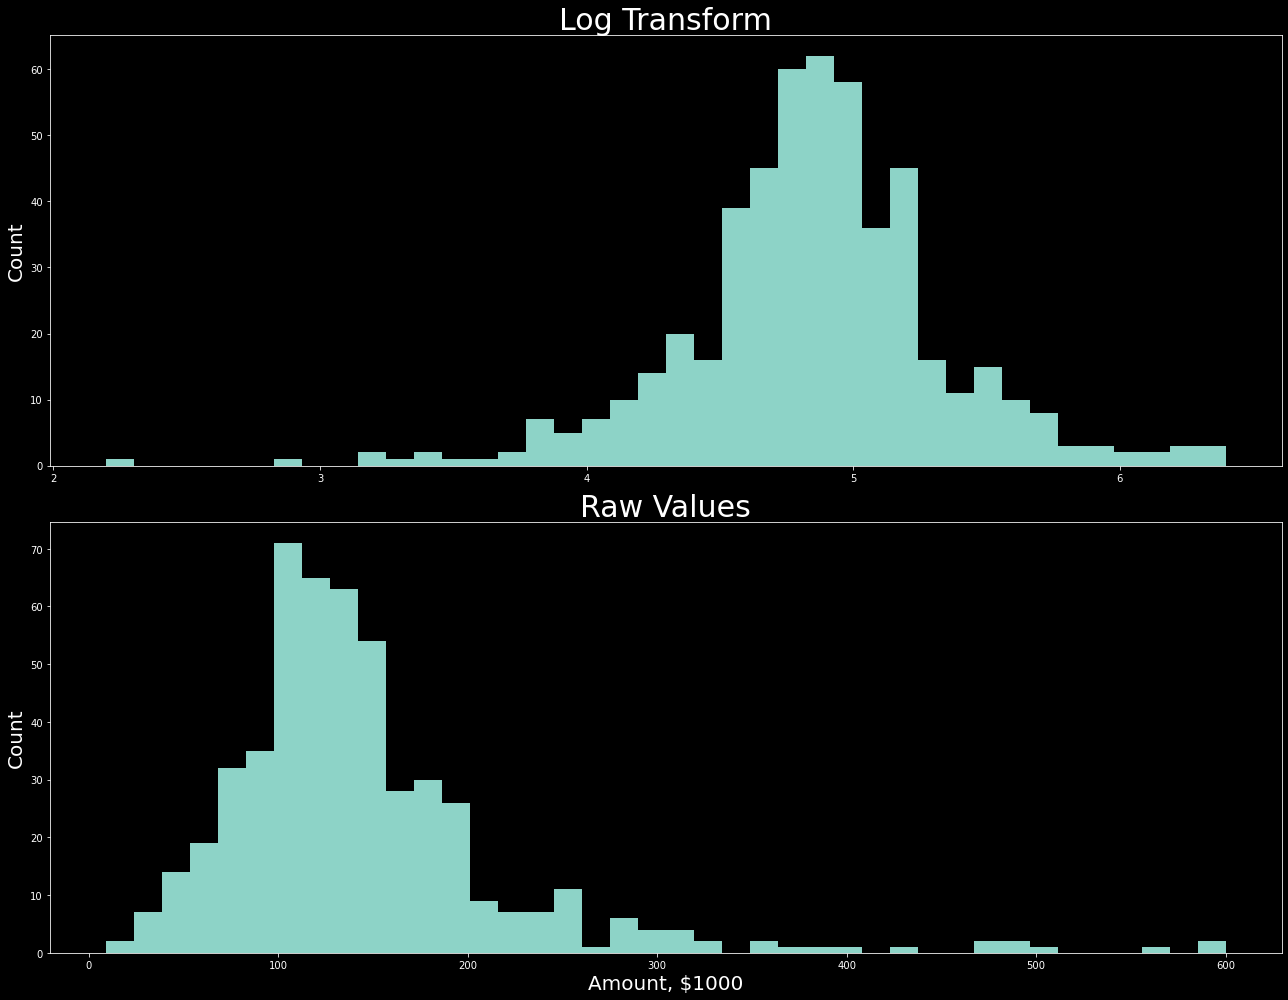

In [126]:
# calculate log values for Loan Amount and plot
xnums_loanLog = np.log(xnums_imputed['LoanAmount'])

fig,ax = plt.subplots(nrows=2, figsize=(18,14))
ax[0].set_title('Log Transform', fontsize=30)
ax[0].set_ylabel('Count', fontsize=20)
# ax[0].set_xlabel('Amount, $1000', fontsize=20)
ax[0].hist(xnums_loanLog, bins=40)
# ax[1].hist(xnums['LoanAmount'], bins=40)

ax[1].set_title('Raw Values', fontsize=30)
ax[1].set_ylabel('Count', fontsize=20)
ax[1].set_xlabel('Amount, $1000', fontsize=20)
# ax[1].hist(logged_loan, bins=40)
ax[1].hist(xnums_imputed['LoanAmount'], bins=40)

plt.tight_layout()
plt.show()

In [127]:
print(xnums_loanLog.describe(), '\n')
print(xnums_imputed['LoanAmount'].describe())

count    511.000000
mean       4.850718
std        0.496852
min        2.197225
25%        4.605170
50%        4.859812
75%        5.108967
max        6.396930
Name: LoanAmount, dtype: float64 

count    511.000000
mean     144.136179
std       78.265134
min        9.000000
25%      100.000000
50%      129.000000
75%      165.500000
max      600.000000
Name: LoanAmount, dtype: float64


### `Function`: Calculating Total Income

Combine both incomes as total income and take a log transformation of the same.

In [128]:
xnums_imputed

,ApplicantIncome,CoapplicantIncome,LoanAmount
0,5849.0,0.0,144.136179
1,4583.0,1508.0,128.000000
2,3000.0,0.0,66.000000
3,2583.0,2358.0,120.000000
4,6000.0,0.0,141.000000
...,...,...,...
506,2900.0,0.0,71.000000
507,4106.0,0.0,40.000000
508,8072.0,240.0,253.000000
509,7583.0,0.0,187.000000


In [129]:
def num_totalIncome(data):
    data_app = data.iloc[:,0]
    data_coapp = data.iloc[:,1]
    data['TotalIncome'] = data_app + data_coapp
    # data['TotalIncome'] = pd.concat([data_applicants, data_coapplicants], axis=1).sum(axis=1)
    data = data.iloc[:,2:]
    return data

In [130]:
xnums_totalIncome = num_totalIncome(xnums_imputed)

In [131]:
xnums_totalIncome

,LoanAmount,TotalIncome
0,144.136179,5849.0
1,128.000000,6091.0
2,66.000000,3000.0
3,120.000000,4941.0
4,141.000000,6000.0
...,...,...
506,71.000000,2900.0
507,40.000000,4106.0
508,253.000000,8312.0
509,187.000000,7583.0


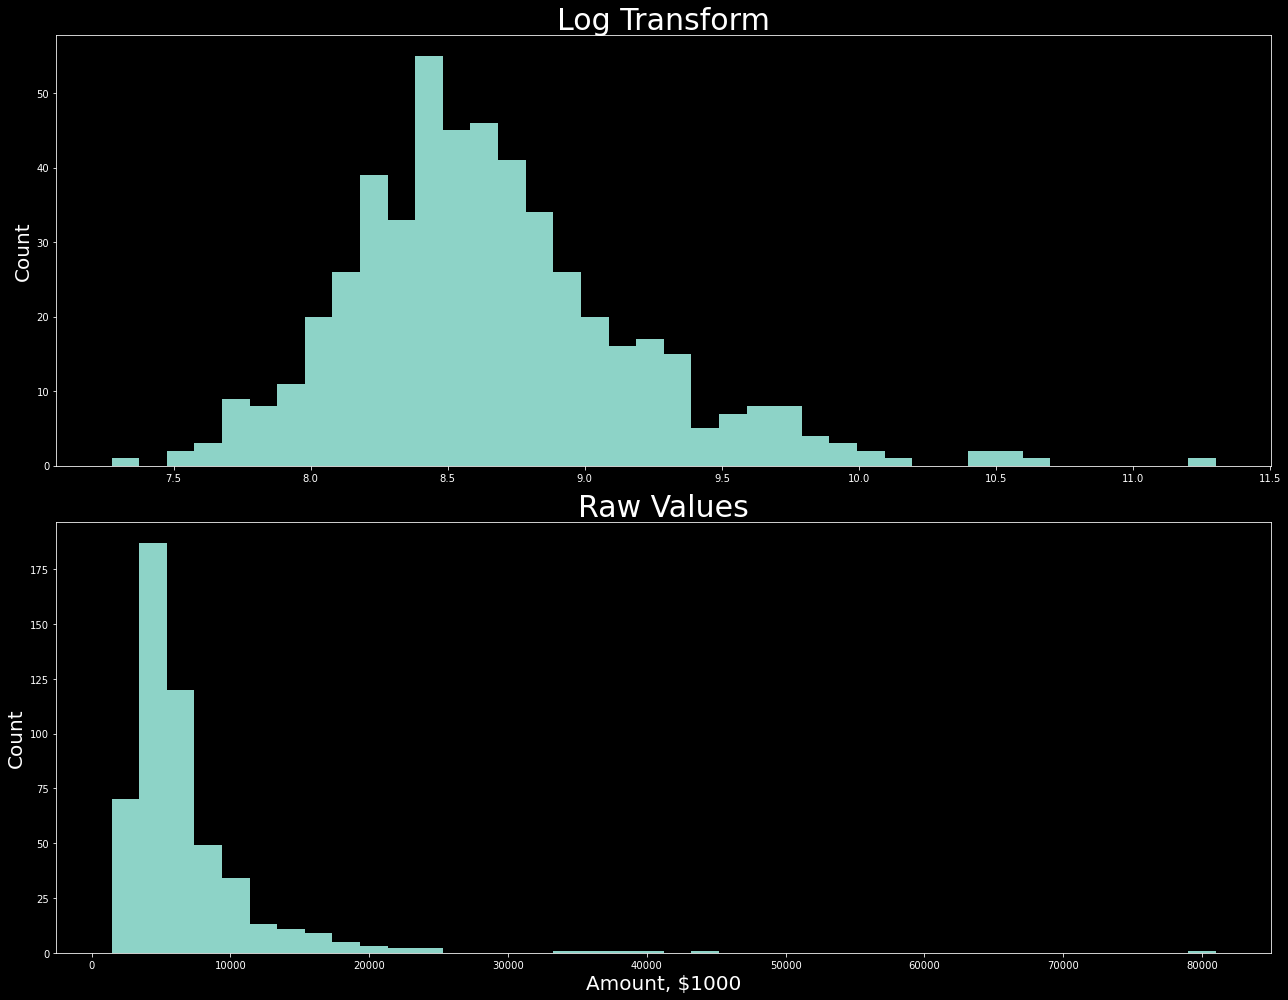

In [132]:
# log transform Total Income and plot
xnums_totalIncomeLog = np.log(xnums_imputed['TotalIncome'])

fig,ax = plt.subplots(nrows=2, figsize=(18,14))
ax[0].set_title('Log Transform', fontsize=30)
ax[0].set_ylabel('Count', fontsize=20)
ax[0].hist(xnums_totalIncomeLog, bins=40)

ax[1].set_title('Raw Values', fontsize=30)
ax[1].set_ylabel('Count', fontsize=20)
ax[1].set_xlabel('Amount, $1000', fontsize=20)
ax[1].hist(xnums_totalIncome['TotalIncome'], bins=40)

plt.tight_layout()
plt.show()

### `Function`: Log Numerical Values

In [133]:
def num_logged(data):
    data = data.apply(np.log)
    return data

In [134]:
xnums_final = num_logged(xnums_totalIncome)
xnums_final.shape

(511, 2)

### Categorical: OneHot and Ordinal Encoding

In [135]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

### `Function`: Separate Nominal and Ordinal Categories

In [136]:
xcats_imputed.head()

,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0,Graduate,No,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,360.0,1.0,Rural
2,Male,Yes,0,Graduate,Yes,360.0,1.0,Urban
3,Male,Yes,0,Not Graduate,No,360.0,1.0,Urban
4,Male,No,0,Graduate,No,360.0,1.0,Urban


In [137]:
# separate categorical variables into nominal and ordinal features
def nom_select(data):
    data = data[['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area','Credit_History']]
    return data

def ord_select(data):
    data = data[['Dependents', 'Loan_Amount_Term']]
    return data

In [138]:
xnoms = nom_select(xcats_imputed)
xords = ord_select(xcats_imputed)

### Encode

In [139]:
# encode binary
ohe = OneHotEncoder(drop='if_binary')
xcats_ohe = ohe.fit_transform(xnoms)

# encode ordinals
ord = OrdinalEncoder()
xcats_ord = ord.fit_transform(xords)

### `Class`: Dense Transformer

In [140]:
class ToDenseTransformer():
    
    def transform(self, x, y=None, **fit_params):
        return x.todense()
    
    def fit(self, x, y=None, **fit_params):
        return self

dense = ToDenseTransformer()

In [141]:
dense.fit(xcats_ohe)
xcats_dense = dense.transform(xcats_ohe)

### `Function`: Restore DataFrames

In [142]:
def nom_df(data):
    data = pd.DataFrame(data, columns=ohe.get_feature_names_out())
    return data

def ord_df(data):
    data = pd.DataFrame(data, columns=ord.feature_names_in_)
    return data

In [143]:
xcats_noms_df = nom_df(xcats_dense)
xcats_ords_df = ord_df(xcats_ord)

In [144]:
print(xcats_noms_df.shape)
print(xcats_ords_df.shape)

(511, 8)
(511, 2)


### Apply `FeatureUnion`()

In [145]:
xcats_final = pd.concat([xcats_noms_df, xcats_ords_df], axis=1)
xcats_final.shape

(511, 10)

## 4. Building a Predictive Model

### Import Packages

In [146]:
# feature selection and reduction
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

### Scale Data using `MinMaxScaler()`

In [147]:
# scale data
std = StandardScaler()
xnums_mm = pd.DataFrame(std.fit_transform(xnums_final))

In [148]:
pca = PCA(n_components=6)
# n_components: [int, float, mle], None default
# whiten: [bool], False default
pca.fit(xcats_final, y)

# PCA results
xcats_pca = pca.transform(xcats_final)

### `Function`: PCA to DataFrame

In [149]:
def cats_pca(data):
    data = pd.DataFrame(data, columns=[f'PCA {i}' for i in range(pca.n_components_)])
    return data

In [150]:
xcats_pca_df = cats_pca(xcats_pca)

### PCA Feature Importance

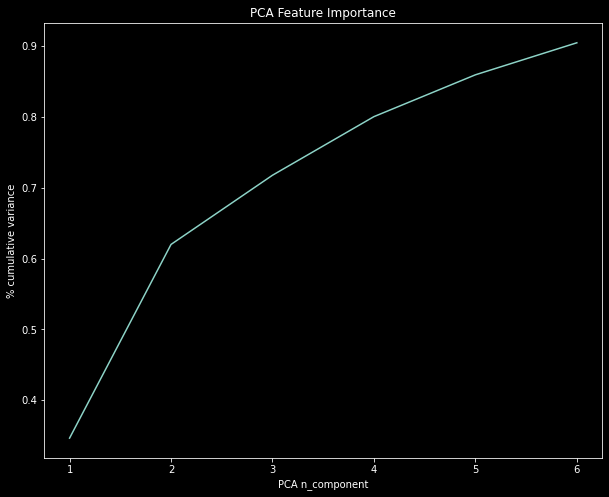

In [151]:
# plot cumulative variance for feature importance
fig,ax = plt.subplots(figsize=(10,8))
ax.set_title('PCA Feature Importance')
ax.set_xlabel('PCA n_component')
ax.set_ylabel('% cumulative variance')
ax.plot(range(1, pca.n_components_ + 1), np.cumsum((pca.explained_variance_ratio_)))

plt.show()

### Apply `FeatureUnion()`

In [152]:
xfinal = pd.concat([xcats_pca_df, xnums_final], axis=1)

In [153]:
xfinal.shape

(511, 8)

In [154]:
### Build Training Sets
from sklearn.model_selection import train_test_split

# create training data
xtrain, xtest, ytrain, ytest = train_test_split(xfinal, y)

In [155]:
print(xtrain.shape)
print(xtest.shape)

(383, 8)
(128, 8)


## Models

In [156]:
# modeling packages
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

### Fit and Predict

In [157]:
lr = LogisticRegression(n_jobs=-1)
# penalties: [l1, l2], l2 default
# solver: [liblinear, saga], lbfgs default
# max_iter: [int], 100 default
# attr: classes_, coef_, intercept_, n_features_in_, features_names_in_, n_iter
lr.fit(xtrain, ytrain)
ylr_pred = lr.predict(xtest)

rf = RandomForestClassifier(n_jobs=-1)
# n_estimators: [int], 100 default
# criterion: [gini, entropy, log_loss], gini default
# max_depth: [int], None default
# min_samples_split: [int, float], 2 default
# min_samples_leaf: [int], 1 default
# max_features: [sqrt, log2, None], sqrt default
# min_impurity_decrease: [float], 0 default
# max_samples: [int, float], None default
# attr: base_estimator_, estimators_, classes_, n_classes_, n_features_in_, feature_names_in_, n_outputs_, feature_importances
rf.fit(xtrain, ytrain)
yrf_pred = rf.predict(xtest)

xg = XGBClassifier(use_label_encoder=False, n_jobs=-1)
# n_estimators: [int], equivalent to number of boosting rounds
# max_depth: [int], None default
# max_leaves: [int], 0 default
# learning_rate: [float], optional
# objective: [reg:logistic, binary:logistic]
# booster: [gbtree, gblinear, dart]
# subsample: [float], optional
# missing: [float], np.nan default
# reg_alpha: [float], optional L1
# reg_lambda: [float], optional L2
xg.fit(xtrain, ytrain)
yxg_pred = xg.predict(xtest)

svc = SVC()
# C: [float], 1 default, regularization parameter
# kernel: [linear, poly, rbf, sigmoid, precomputed], rbf default
# (for kernel:poly) degree: [int], 3 default
# max_iter: [int], -1 default

nv = BernoulliNB()
# alpha: [float], 1 default
# binarize: [float, None], 0 default
# fit_prior: [bool], True default
# class_prior: [array of n_classes], None default
# attr: class_count_, class_log_prior_, classes_, feature_count_, feature_lob_prob_, n_features_in_, feature_names_in_
nv.fit(xtrain, ytrain)
ynv_pred = nv.predict(xtest)

[23:47:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


### Evaluations

In [158]:
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, precision_recall_curve
import seaborn as sns

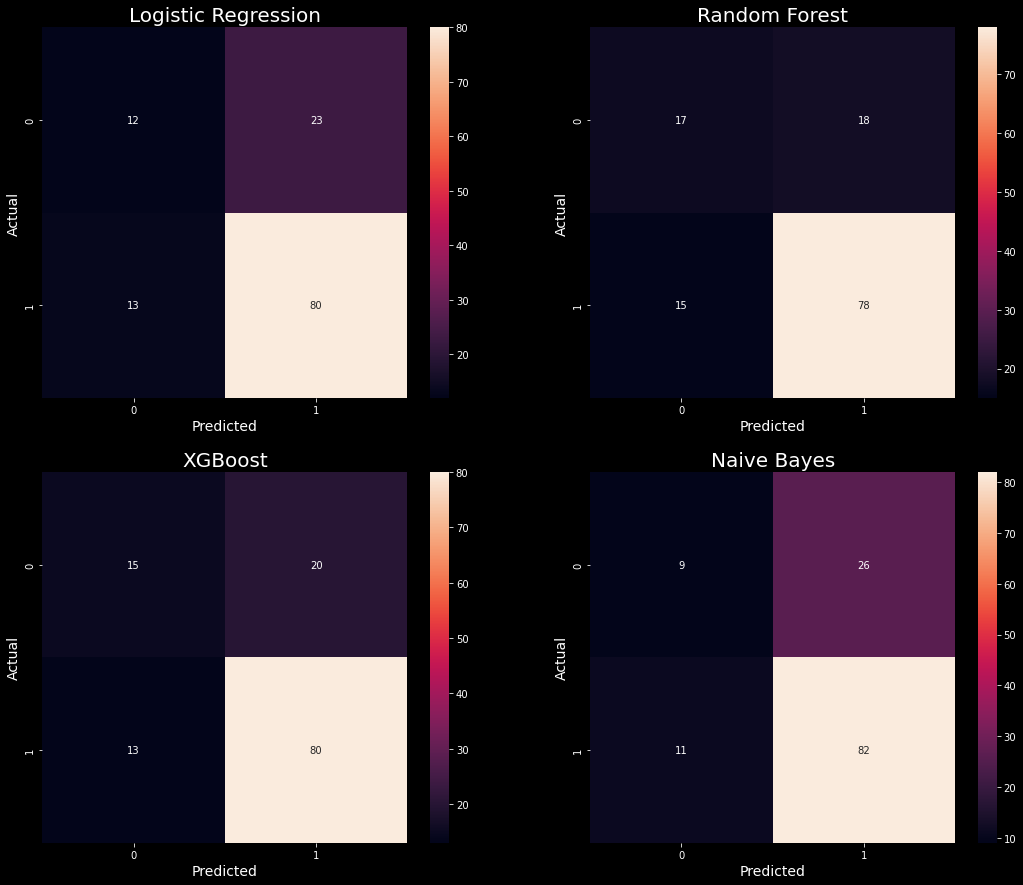

In [159]:
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(18,15))

ax[0,0].set_title('Logistic Regression', fontsize=20)
ax[0,1].set_title('Random Forest', fontsize=20)
ax[1,0].set_title('XGBoost', fontsize=20)
ax[1,1].set_title('Naive Bayes', fontsize=20)

sns.heatmap(confusion_matrix(ytest, ylr_pred), ax=ax[0,0], annot=True)
sns.heatmap(confusion_matrix(ytest, yrf_pred), ax=ax[0,1], annot=True)
sns.heatmap(confusion_matrix(ytest, yxg_pred), ax=ax[1,0], annot=True)
sns.heatmap(confusion_matrix(ytest, ynv_pred), ax=ax[1,1], annot=True)

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xlabel('Predicted', fontsize=14)
        ax[i,j].set_ylabel('Actual', fontsize=14)

In [160]:
# example confusion matrix values
tn, fp, fn, tp = confusion_matrix(ytest, ylr_pred).ravel()
print(tn, fp, fn, tp)

12 23 13 80


In [161]:
# classification reports
print('***************** Logistic Regression *****************\n\n', classification_report(ytest, ylr_pred, zero_division=0))
print('******************** Random Forest ********************\n\n', classification_report(ytest, yrf_pred, zero_division=0))
print('*********************** XGBoost ***********************\n\n', classification_report(ytest, yxg_pred, zero_division=0))
print('********************* Naive Bayes *********************\n\n', classification_report(ytest, ynv_pred, zero_division=0))

***************** Logistic Regression *****************

               precision    recall  f1-score   support

           0       0.48      0.34      0.40        35
           1       0.78      0.86      0.82        93

    accuracy                           0.72       128
   macro avg       0.63      0.60      0.61       128
weighted avg       0.70      0.72      0.70       128

******************** Random Forest ********************

               precision    recall  f1-score   support

           0       0.53      0.49      0.51        35
           1       0.81      0.84      0.83        93

    accuracy                           0.74       128
   macro avg       0.67      0.66      0.67       128
weighted avg       0.74      0.74      0.74       128

*********************** XGBoost ***********************

               precision    recall  f1-score   support

           0       0.54      0.43      0.48        35
           1       0.80      0.86      0.83        93

    accu

In [162]:
# set grid parameters for all models
param_lr = {
    'penalty': ['l1','l2'],
    'solver' : ['liblinear', 'saga'],
    'max_iter' : [3, 10, 100]
}

param_rf = {
    'n_estimators' : [5, 10, 50],
    'max_depth' : [2, 3, 5, 10],
    'min_samples_split' : [2, 3, 4]
}

param_xg = {
    'objective' : ['reg:logistic', 'binary:logistic'],
    'n_estimators' : [30, 50, 80],
    'max_depth' : [2, 3, 5],
    'learning_rate' : [0.001, 0.003, 0.01, 0.03, 0.1],
}

param_nv = {
    'alpha' : [0.1, 0.3, 1, 3, 10]
}

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


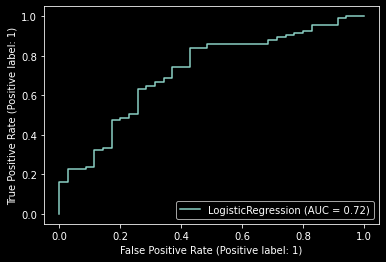

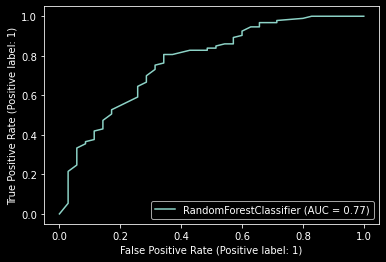

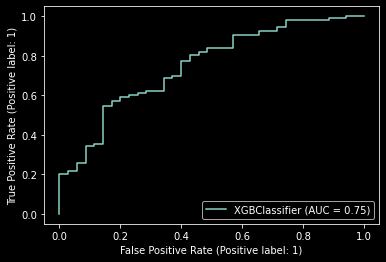

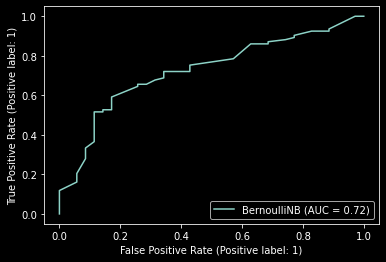

In [163]:
RocCurveDisplay.from_estimator(lr, xtest, ytest)
RocCurveDisplay.from_estimator(rf, xtest, ytest)
RocCurveDisplay.from_estimator(xg, xtest, ytest)
RocCurveDisplay.from_estimator(nv, xtest, ytest)

In [164]:
precision_lr, recall_lr, _ = precision_recall_curve(ytest, ylr_pred)
precision_rf, recall_rf, _ = precision_recall_curve(ytest, yrf_pred)
precision_xg, recall_xg, _ = precision_recall_curve(ytest, yxg_pred)
precision_nv, recall_nv, _ = precision_recall_curve(ytest, ynv_pred)

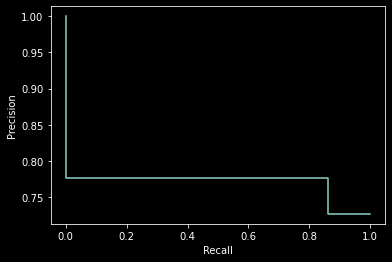

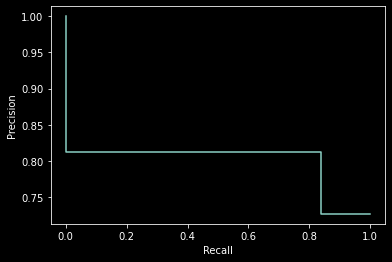

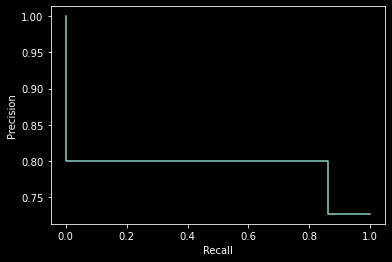

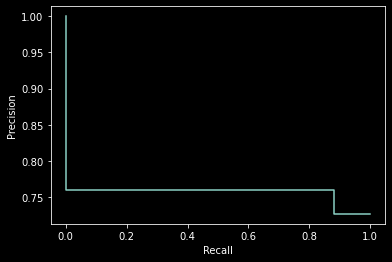

In [165]:
PrecisionRecallDisplay(precision_lr, recall_lr).plot()
PrecisionRecallDisplay(precision_rf, recall_rf).plot()
PrecisionRecallDisplay(precision_xg, recall_xg).plot()
PrecisionRecallDisplay(precision_nv, recall_nv).plot()

### Evaluations with Grid Search

In [166]:
gscv_lr = GridSearchCV(lr, param_lr, n_jobs=-1, refit=True, cv=5)
gscv_rf = GridSearchCV(rf, param_rf, n_jobs=-1, refit=True, cv=5)
gscv_xg = GridSearchCV(xg, param_xg, n_jobs=-1, refit=True, cv=5)
gscv_nv = GridSearchCV(nv, param_nv, n_jobs=-1, refit=True, cv=5)

In [167]:
gscv_lr.fit(xtrain, ytrain)
gscv_rf.fit(xtrain, ytrain)
gscv_xg.fit(xtrain, ytrain)
gscv_nv.fit(xtrain, ytrain)

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/skle

[23:47:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:49] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:47:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:49] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:47:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:50] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:47:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:52] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:47:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:53] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:47:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:54] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:47:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:56] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:47:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:58] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:00] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:04] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:04] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:05] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:06] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:07] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:08] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:11] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:12] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:14] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:18] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:18] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:19] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:21] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:21] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:23] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:25] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:26] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:28] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:32] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:46] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:47] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:47] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:49] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:50] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:51] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:53] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:54] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:48:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base

[23:48:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:56] WARNING: /Users/runner/miniforge3/cond

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


GridSearchCV(cv=5, estimator=BernoulliNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.3, 1, 3, 10]})

In [168]:
ylr_gs_pred = gscv_lr.predict(xtest)
yrf_gs_pred = gscv_rf.predict(xtest)
yxg_gs_pred = gscv_xg.predict(xtest)
ynv_gs_pred = gscv_nv.predict(xtest)

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


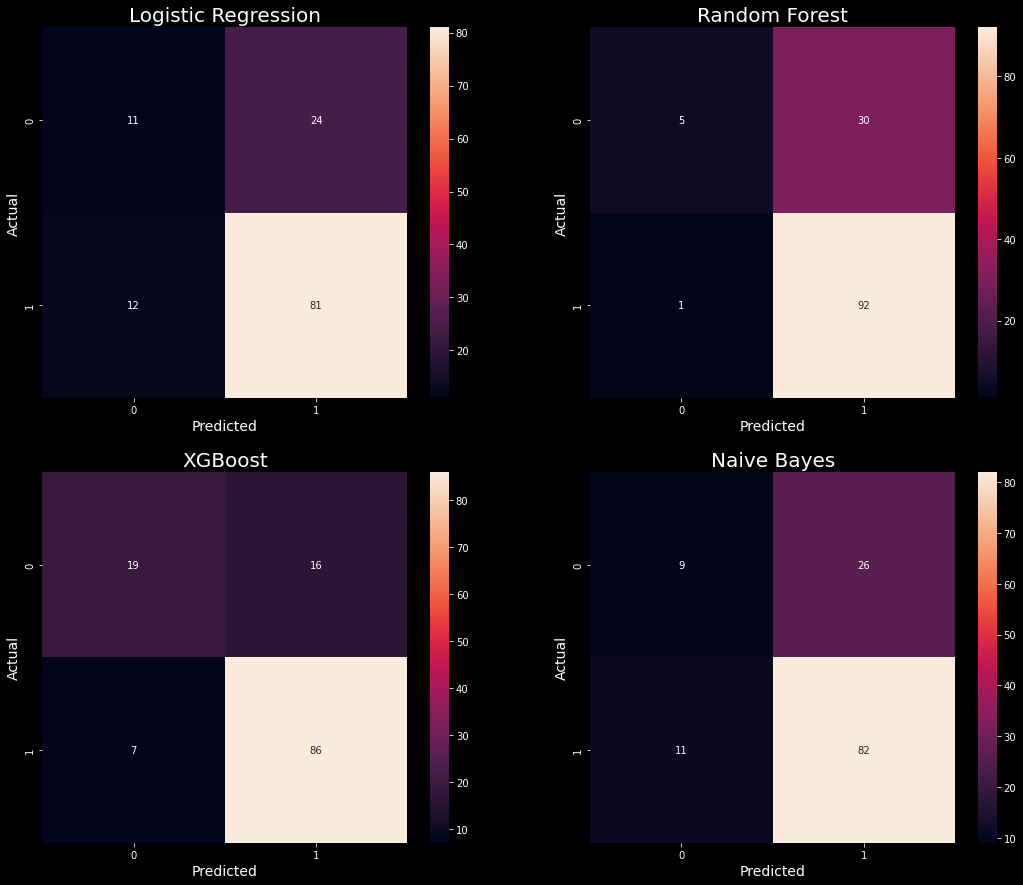

In [169]:
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(18,15))

ax[0,0].set_title('Logistic Regression', fontsize=20)
ax[0,1].set_title('Random Forest', fontsize=20)
ax[1,0].set_title('XGBoost', fontsize=20)
ax[1,1].set_title('Naive Bayes', fontsize=20)

sns.heatmap(confusion_matrix(ytest, ylr_gs_pred), ax=ax[0,0], annot=True)
sns.heatmap(confusion_matrix(ytest, yrf_gs_pred), ax=ax[0,1], annot=True)
sns.heatmap(confusion_matrix(ytest, yxg_gs_pred), ax=ax[1,0], annot=True)
sns.heatmap(confusion_matrix(ytest, ynv_gs_pred), ax=ax[1,1], annot=True)

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xlabel('Predicted', fontsize=14)
        ax[i,j].set_ylabel('Actual', fontsize=14)

In [170]:
print('************* Logistic Regression (GSCV) **************\n\n', classification_report(ytest, ylr_gs_pred, zero_division=0))
print('***************** Random Forest (GSCV) ****************\n\n', classification_report(ytest, yrf_gs_pred, zero_division=0))
print('******************** XGBoost (GSCV) ********************\n\n', classification_report(ytest, yxg_gs_pred, zero_division=0))
print('****************** Naive Bayes (GSCV) ******************\n\n', classification_report(ytest, ynv_gs_pred, zero_division=0))

************* Logistic Regression (GSCV) **************

               precision    recall  f1-score   support

           0       0.48      0.31      0.38        35
           1       0.77      0.87      0.82        93

    accuracy                           0.72       128
   macro avg       0.62      0.59      0.60       128
weighted avg       0.69      0.72      0.70       128

***************** Random Forest (GSCV) ****************

               precision    recall  f1-score   support

           0       0.83      0.14      0.24        35
           1       0.75      0.99      0.86        93

    accuracy                           0.76       128
   macro avg       0.79      0.57      0.55       128
weighted avg       0.78      0.76      0.69       128

******************** XGBoost (GSCV) ********************

               precision    recall  f1-score   support

           0       0.73      0.54      0.62        35
           1       0.84      0.92      0.88        93

    acc

In [171]:
print(gscv_lr.best_params_)
print(gscv_rf.best_params_)
print(gscv_xg.best_params_)
print(gscv_nv.best_params_)

{'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
{'max_depth': 2, 'min_samples_split': 4, 'n_estimators': 10}
{'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 30, 'objective': 'reg:logistic'}
{'alpha': 10}


## 5. Using Pipeline

If you didn't use pipelines before, transform your data prep, feat. engineering and modeling steps into Pipeline. It will be helpful for deployment.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

### Define Function Transformers

In [172]:
from sklearn.preprocessing import FunctionTransformer

In [173]:
# using a FunctionTransformer to separate numerical values from categories
num_selector = FunctionTransformer(num_select)
cat_selector = FunctionTransformer(num_select)

In [174]:
num_imputer = FunctionTransformer(num_imputed)
cat_imputer = FunctionTransformer(cat_imputed)

In [175]:
num_totaler = FunctionTransformer(num_totalIncome)

In [176]:
num_logger = FunctionTransformer(num_logged)

In [177]:
nom_selector = FunctionTransformer(nom_select)
ord_selector = FunctionTransformer(ord_select)

In [178]:
nom_dframer = FunctionTransformer(nom_df)
ord_dframer = FunctionTransformer(ord_df)

In [179]:
cat_pcer = FunctionTransformer(cats_pca)

### Pipeline Model

In [180]:
# preprocessing packages
from sklearn.impute import SimpleImputer

# pipeline packages
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

# numerical pipeline
num_pipe = Pipeline([
    ('selector', num_selector),
    ('imputer', num_imputer),
    ('totaler', num_totaler),
    ('logger', num_logger),
    ('scaler', std),
])

In [181]:
# categorical pipeline
cat_pipe = Pipeline([
    ('selector', cat_selector),
    ('imputer', cat_imputer),
    ('columner', ColumnTransformer([
        ('onehotter', ohe, ['Gender', 'Married', 'Educatioan', 'Self_Employed', 'Property_Area','Credit_History']),
    #     ('denser', dense, ['Gender', 'Married', 'Educatioan', 'Self_Employed', 'Property_Area','Credit_History']),
    #     ('orderer', ord, ['Dependents', 'Loan_Amount_Term'])
])),
    # ('pcer', cat_pcer)
])

In [182]:
features = FeatureUnion([
    ('num_features', num_pipe),
    ('cat_features', cat_pipe)
])

In [183]:
# final
model = Pipeline([
    ('features', features),
    ('model', xg)
])

## 6. Deploy your model to cloud and test it with PostMan, BASH or Python

In [184]:
cat_pipe.fit(xtrain, ytrain)

ValueError: A given column is not a column of the dataframe

In [ ]:
ypred = 

In [ ]:
import pickle

filename = 'xgb_pipeline.sav'
pickle.dump(model, open(filename, 'wb'))